# Custom Mask R-CNN Training

Training notebook for custom Mask R-CNN with EfficientNet backbone and CBAM attention.


In [1]:
!git clone https://github.com/michaelo-ponteski/isaid-instance-segmentation.git
%cd isaid-instance-segmentation/

Cloning into 'isaid-instance-segmentation'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 321 (delta 21), reused 27 (delta 12), pack-reused 278 (from 1)
Receiving objects: 100% (321/321), 5.19 MiB | 31.44 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/kaggle/working/isaid-instance-segmentation


In [2]:
!git pull origin ponteski_2

From https://github.com/michaelo-ponteski/isaid-instance-segmentation
 * branch            ponteski_2 -> FETCH_HEAD
Updating ebf8d65..67b518b
Fast-forward
 .gitignore                   |    11 +
 config.yaml                  |    41 +
 datasets/isaid_dataset.py    |   160 +-
 models/__init__.py           |    35 +
 models/backbone.py           |   229 +
 models/maskrcnn_model.py     |   466 +-
 models/roi_heads.py          |   226 +
 notebooks/00_setup.ipynb     |   891 ++--
 notebooks/01_training.ipynb  | 10276 +++++++++++++++++++++++++++++++++++++++++
 notebooks/02_anchoropt.ipynb |   617 +++
 requirements.txt             |    10 +
 training/__init__.py         |    21 +
 training/anchor_optimizer.py |   655 +++
 training/trainer.py          |  1389 ++++++
 training/transforms.py       |    55 +
 utils/__init__.py            |     7 +
 utils/overfit_test.py        |   278 +-
 17 files changed, 14700 insertions(+), 667 deletions(-)
 create mode 100644 .gitignore
 create mode 100644 co

In [3]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("michaeloponteski/isaid-patches")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isaid-patches


In [4]:
import torch
import matplotlib.pyplot as plt
import importlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.1 GB


In [ ]:
# Reload modules for development
import datasets.isaid_dataset
import models.maskrcnn_model
import models.backbone
import utils.overfit_test
import training.trainer
import training.transforms

importlib.reload(datasets.isaid_dataset)
importlib.reload(models.maskrcnn_model)
importlib.reload(models.backbone)
importlib.reload(utils.overfit_test)
importlib.reload(training.trainer)
importlib.reload(training.transforms)

from datasets.isaid_dataset import visualize_sample
from models.maskrcnn_model import CustomMaskRCNN
from models.backbone import BackboneWithFPN, build_custom_backbone_with_fpn
from utils.overfit_test import overfit_test
from training import create_datasets

## Load Dataset


In [6]:
root_dir = path + "/iSAID_patches"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 16

In [7]:
# Create datasets ONCE - can be reused for multiple training runs
train_dataset, val_dataset = create_datasets(
    data_root=root_dir,
    image_size=800,
    subset_fraction=0.1,  # Use full dataset (set < 1.0 for quick testing)
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

Loading datasets...
Filtered dataset: 18732 images with annotations
Filtered dataset: 6048 images with annotations
Using 10.0% of data: 1873 train, 604 val samples
Train: 1873, Val: 604


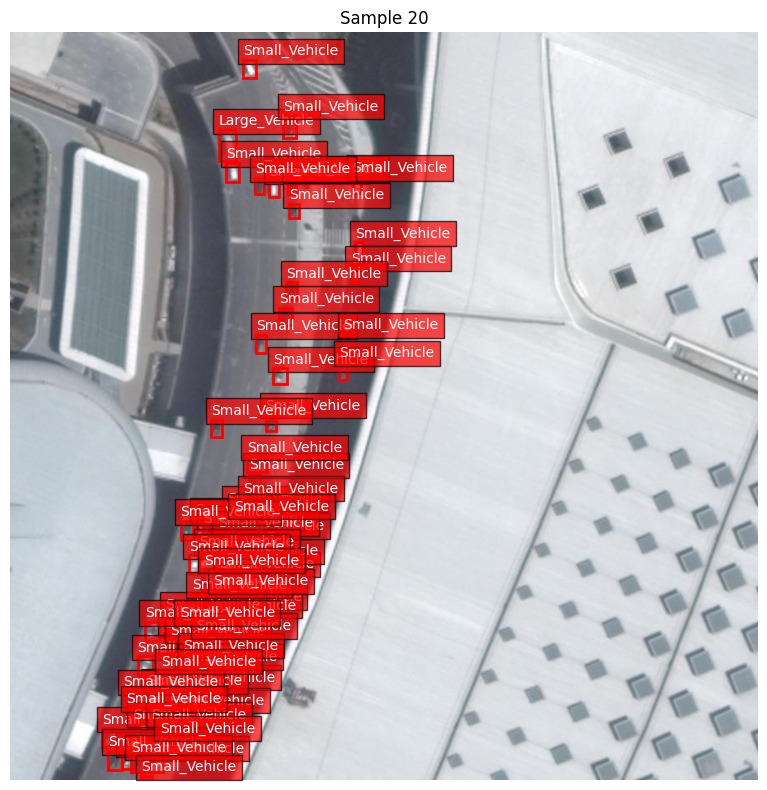

In [8]:
# Visualize a sample
visualize_sample(train_dataset, 20)

## Create Model


In [9]:
# Build backbone with FPN (default: EfficientNet + CBAM attention)
backbone, fpn, fpn_out_channels = build_custom_backbone_with_fpn(pretrained=True)
backbone_with_fpn = BackboneWithFPN(backbone, fpn)

# Create model with the backbone
model = CustomMaskRCNN(
    num_classes=num_classes,
    backbone_with_fpn=backbone_with_fpn,
    pretrained_backbone=True,
)

# Model info
info = model.get_model_info()
print(f"Total parameters: {info['total_parameters']:,}")
print(f"Trainable parameters: {info['trainable_parameters']:,}")
print(f"Model size: {info['model_size_mb']:.1f} MB")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]


Total parameters: 24,315,626
Trainable parameters: 24,315,626
Model size: 92.9 MB


## Overfit Image Test

Sanity check - can the model learn to overfit a single image?


OVERFIT TEST (3 IMAGES)

Image 1 (idx=19):
  Shape: torch.Size([3, 800, 800])
  Instances: 33
  Classes: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

Image 2 (idx=20):
  Shape: torch.Size([3, 800, 800])
  Instances: 62
  Classes: [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

Image 3 (idx=21):
  Shape: torch.Size([3, 800, 800])
  Instances: 9
  Classes: [8, 8, 9, 9, 9, 9, 14, 14, 14]

Training for 400 epochs on 3 images...
Epoch [10/400], Loss: 1.7622
  loss_objectness: 0.6745
  loss_rpn_box_reg: 0.0681
  loss_classifier: 0.4689
  loss_box_reg: 0.0500
  loss_mask: 0.5008
Epoch [20/400], Loss: 1.6174
  loss_objectness: 0.6302
  loss_rpn_box_reg: 0.0626
  loss_classifier: 0.3258
  loss_box_reg: 0.2301
  loss_mask: 0.3687
Epoch [30/400], Loss: 1.5144
  loss_objectness: 0.5596
  loss_rpn_box_reg:

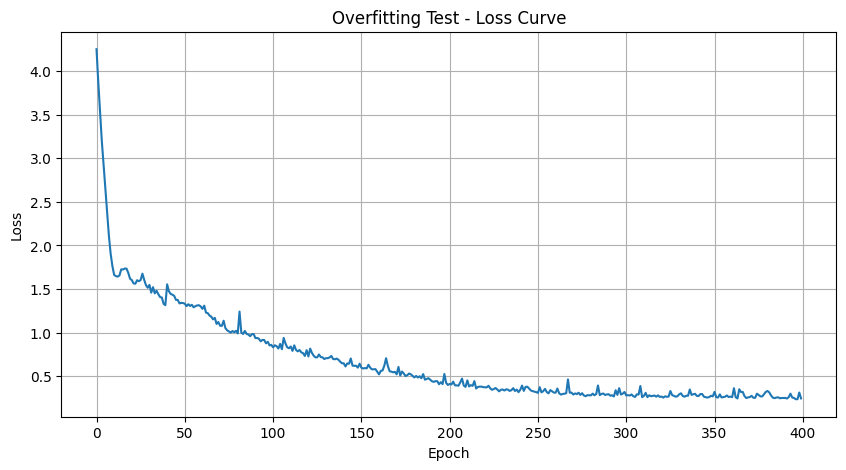


--- Image 1 Results ---


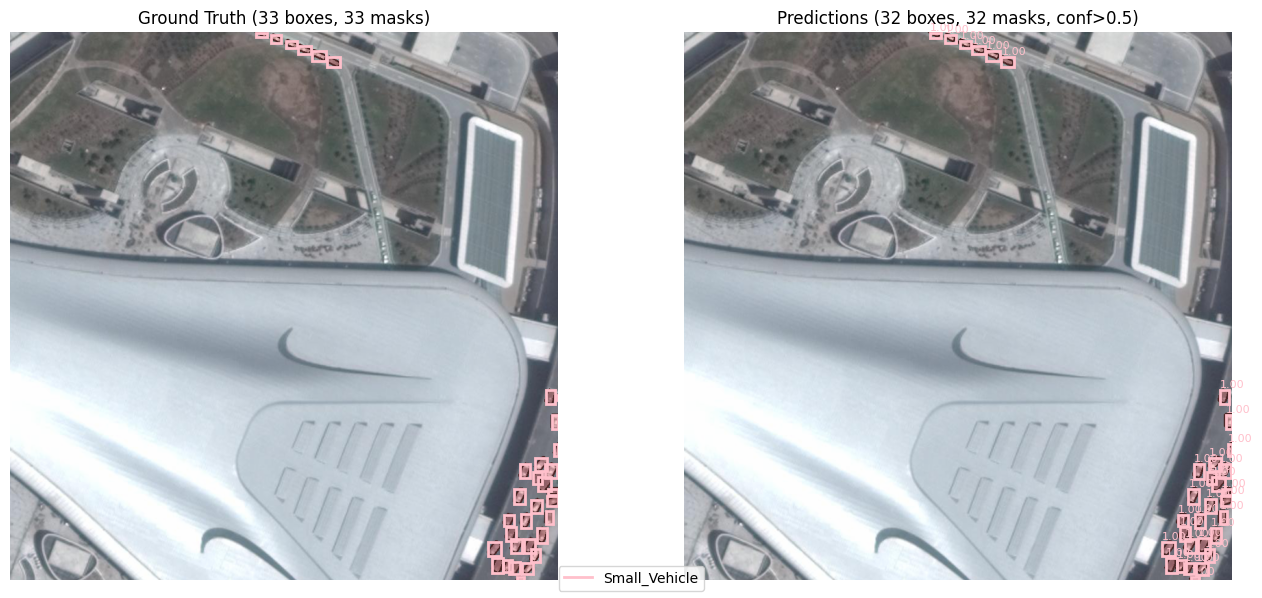


Found 32 boxes (should be 33)
Found 32 masks (should be 33)

--- Image 2 Results ---


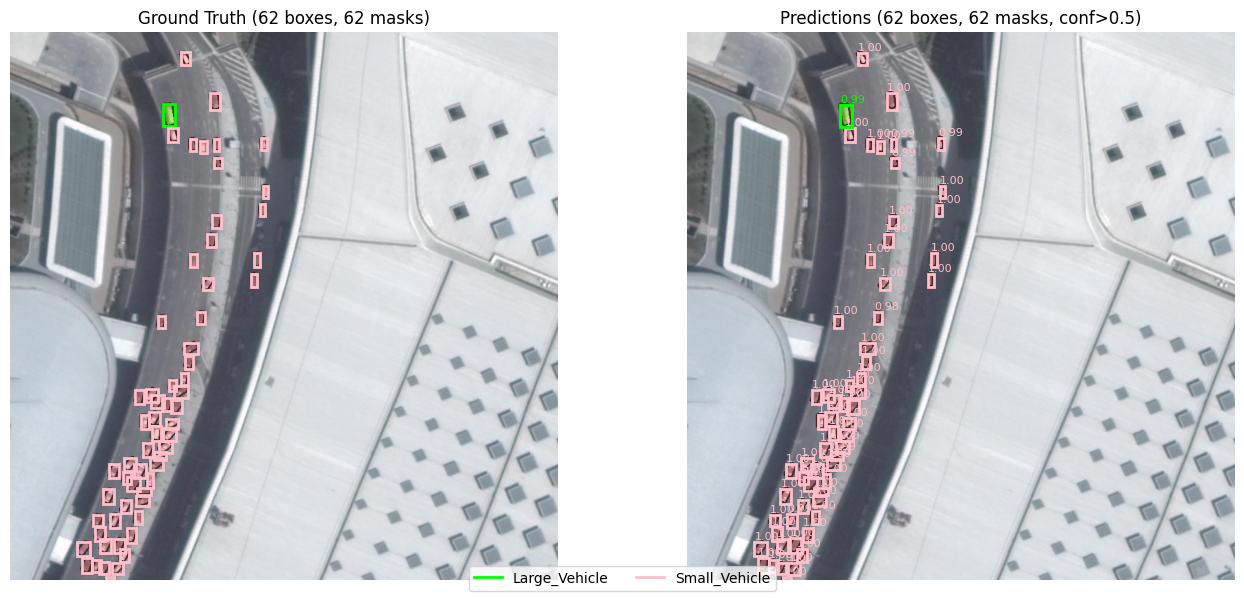


Found 62 boxes (should be 62)
Found 62 masks (should be 62)

--- Image 3 Results ---


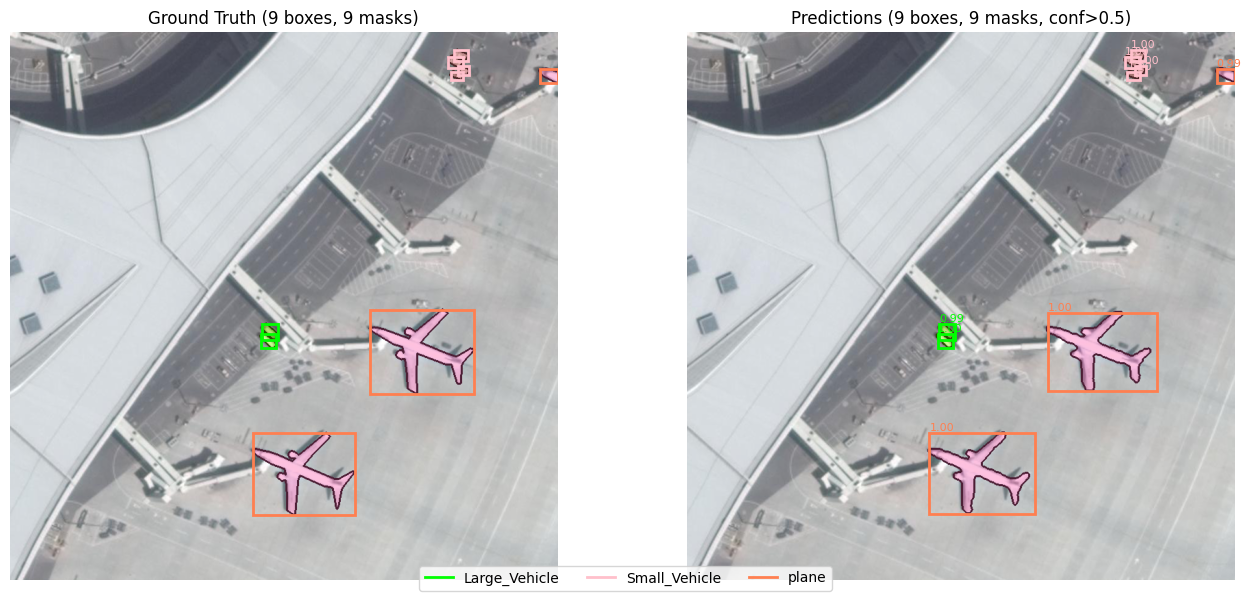


Found 9 boxes (should be 9)
Found 9 masks (should be 9)

RESULTS:
Initial Loss: 4.2511
Final Loss: 0.2446
Improvement: 94.2%


In [ ]:
# Run overfit test on 3 images (sanity check)
losses, preds = overfit_test(
    model, train_dataset, idx=19, num_epochs=400, device=device, num_images=3
)